# Puerto Rico Power Plants Data Analysis `Kaggle Competition`
This notebook builds on exploratory data analysis provided for Kaggle's data analytics competition: DS4G: Environmental Insights Explorer

### Summary 
The goal of this notebook is to build on exploratory power plant data analysis and visulizations from map and satellite data
### Objective
The ultimate goal is to "develop a methodology to calculate an average historical emissions factor of electricity generated for a sub-national region, using remote sensing data and techniques" as per the competition's definition ([Kaggle DS4G competition homepage](https://www.kaggle.com/c/ds4g-environmental-insights-explorer "Competition homepage")).

At this time, exploratory data analysis is performed, such as the capacity, source of information, energy source and location of the power plants. Also, the satellite images (rasters) are analysed for the different satellite bands and overlaid on a Folium map. 
### Method
The processes within this Notebook is presented as:
- Data analysis in Pandas
- Primary visualisations in Matplotlib.pyplot and Seaborn
- Map data visualisation in Folium
- Satellite ratster images analysed and visualised using Rasterio  

### References
https://www.kaggle.com/parulpandey/understanding-the-data  
https://www.kaggle.com/paultimothymooney/overview-of-the-eie-analytics-challenge  
https://www.kaggle.com/paultimothymooney/explore-image-metadata-s5p-gfs-gldas

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import tifffile as tiff

In [3]:
#!pip install imagecodecs
import imagecodecs

In [4]:
import seaborn as sns

C:\Users\Dominic Fabian\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
import os

In [6]:
import datetime as dt
from datetime import datetime

In [7]:
import folium
import rasterio as rio

In [8]:
# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

In [9]:
pd.set_option('max_columns',None)

## Exploratory analysis of Puerto Rico power plant dataset

In [10]:
#Power plants in Puerto Rico
global_power_plants = pd.read_csv('./eie_data/gppd/gppd_120_pr.csv')
print(global_power_plants.shape)
global_power_plants.head(3)

(35, 24)


,system:index,capacity_mw,commissioning_year,country,country_long,estimated_generation_gwh,generation_gwh_2013,generation_gwh_2014,generation_gwh_2015,generation_gwh_2016,generation_gwh_2017,geolocation_source,gppd_idnr,name,other_fuel1,other_fuel2,other_fuel3,owner,primary_fuel,source,url,wepp_id,year_of_capacity_data,.geo
0,0000000000000000315a,15.0,1942.0,USA,United States of America,685.397712,0.0,0.0,0.0,0.0,0.0,WRI,WRI1026827,Dos Bocas,NaN,NaN,NaN,PREPA,Hydro,CEPR,http://energia.pr.gov/datos/plantas/,30936.0,0,"{""type"":""Point"",""coordinates"":[-66.66629863706..."
1,000000000000000026e5,1492.0,1975.0,USA,United States of America,8334.010812,0.0,0.0,0.0,0.0,0.0,WRI,WRI1026809,Aguirre,NaN,NaN,NaN,PREPA,Oil,PREPA,http://www.prepa.com/aguirre.asp,30928.0,0,"{""type"":""Point"",""coordinates"":[-66.23079607357..."
2,00000000000000002fda,990.0,1962.0,USA,United States of America,5529.940150,0.0,0.0,0.0,0.0,0.0,WRI,WRI1026811,Costa Sur,NaN,NaN,NaN,PREPA,Oil,PREPA,http://www.prepa.com/costasur.asp,30934.0,0,"{""type"":""Point"",""coordinates"":[-66.75340271704..."


In [11]:
global_power_plants.primary_fuel.value_counts()

Hydro    11
Gas       9
Solar     6
Oil       6
Wind      2
Coal      1
Name: primary_fuel, dtype: int64

Text(0, 0.5, 'count')

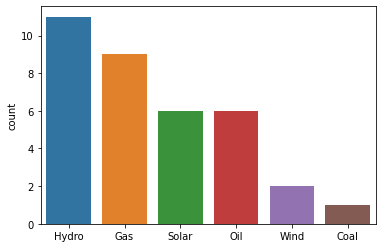

In [12]:
sns.barplot(x=global_power_plants.primary_fuel.value_counts().index, y=global_power_plants.primary_fuel.value_counts().values)
plt.ylabel('count')

Text(0, 0.5, 'count')

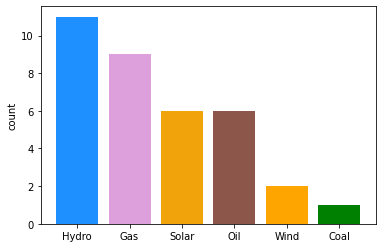

In [13]:
colors = ['dodgerblue', 'plum', '#F0A30A','#8c564b','orange','green','yellow']
plt.bar(x=global_power_plants.primary_fuel.value_counts().index, height=global_power_plants.primary_fuel.value_counts().values,color=colors)
plt.ylabel('count')

In [14]:
global_power_plants.commissioning_year.value_counts()

0.0       21
2012.0     2
1941.0     2
2015.0     1
2011.0     1
2009.0     1
1937.0     1
1929.0     1
1915.0     1
1960.0     1
1962.0     1
1975.0     1
1942.0     1
Name: commissioning_year, dtype: int64

Text(0.5, 0, 'count')

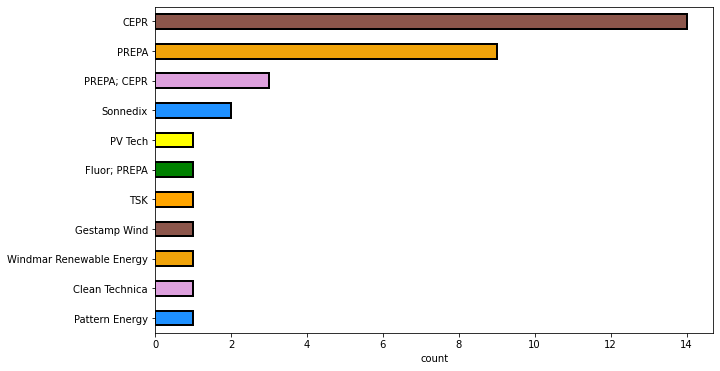

In [15]:
fig= plt.gcf()
fig.set_size_inches(10,6)
colors = ['dodgerblue', 'plum', '#F0A30A','#8c564b','orange','green','yellow']
global_power_plants.source.value_counts(ascending=True).plot(kind='barh',linewidth=2,color=colors,edgecolor='black')
plt.xlabel('count')

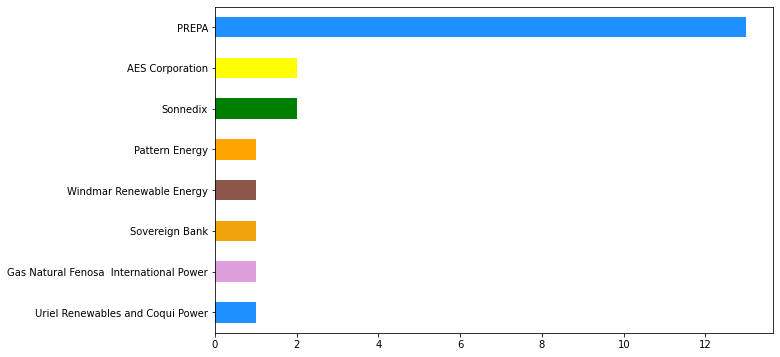

In [16]:
fig = plt.gcf()
fig.set_size_inches(10,6)
global_power_plants.owner.value_counts(ascending=True).plot(kind='barh',color= colors)

In [17]:
total_capacity_mw = global_power_plants.capacity_mw.sum()
total_capacity_mw

6148.449985861778

In [18]:
capacity = (global_power_plants.groupby('primary_fuel')['capacity_mw'].sum()).to_frame()
capacity = capacity.sort_values('capacity_mw',ascending=False)
capacity['percentage_of_total'] = (capacity.capacity_mw/total_capacity_mw)*100
capacity

,capacity_mw,percentage_of_total
primary_fuel,,
Oil,4201.500000,68.334296
Gas,1105.000000,17.972009
Coal,454.299988,7.388854
Solar,154.650002,2.515268
Wind,124.599997,2.026527
Hydro,108.400000,1.763046


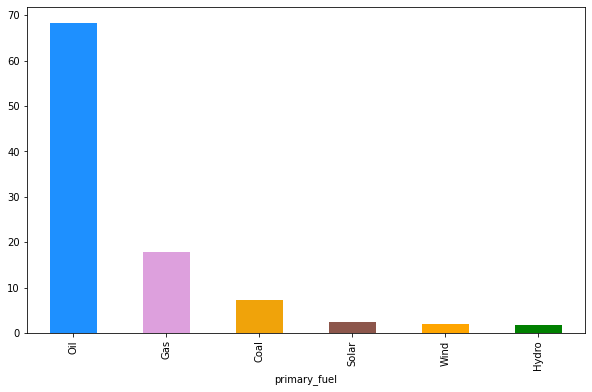

In [19]:
fig = plt.gcf()
fig.set_size_inches(10,6)
colors = ['dodgerblue', 'plum', '#F0A30A','#8c564b','orange','green','yellow']
capacity.percentage_of_total.plot(kind='bar',color=colors)

In [20]:
total_gen_mw = global_power_plants.estimated_generation_gwh.sum()
print('Total Generatation: '+'{:.2f}'.format(total_gen_mw) + ' GW')

Total Generatation: 486860.88 GW


In [21]:
generation = global_power_plants.groupby('primary_fuel').sum()['estimated_generation_gwh'].to_frame()
generation = generation.sort_values('estimated_generation_gwh',ascending=False)
generation['percentage_of_total'] = (generation.estimated_generation_gwh/total_gen_mw)*100
generation

,estimated_generation_gwh,percentage_of_total
primary_fuel,,
Coal,450562.692350,92.544444
Oil,23468.730848,4.820418
Gas,7785.243454,1.599069
Hydro,4953.140798,1.017363
Solar,68.962714,0.014165
Wind,22.104981,0.004540


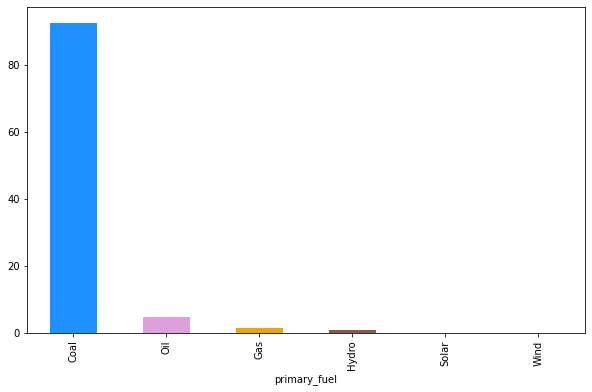

In [22]:
fig = plt.gcf()
fig.set_size_inches(10,6)
generation.percentage_of_total.plot(kind='bar', color=colors)

In [23]:
from folium import plugins

In [24]:
#dissociate latitude and longitude from '.geo' column
for i in range(0,len(global_power_plants)):
    global_power_plants.loc[i,'latitude'] = global_power_plants.at[i,'.geo'][50:66]
    global_power_plants.loc[i,'longitude'] = global_power_plants.at[i,'.geo'][31:48]

global_power_plants.latitude = global_power_plants.latitude.astype(float)

In [25]:
#problem with some latitudes being 10 less than the true value
a = np.array(global_power_plants.latitude.tolist())
global_power_plants.latitude = np.where(a<10, a+10, a)

In [26]:
#power plants on map
location=[18.200178,-66.664513] #Puerto Rico latitude & longitude (north easting)
zoom = 9
plot = folium.Map(location=location, zoom_start=zoom, tiles='Stamen Terrain')

for i in range(0,len(global_power_plants)):
    
    popup = folium.Popup(html=str(global_power_plants.primary_fuel[i:i+1]))
    
    folium.Marker(location=[global_power_plants.latitude.iloc[i],global_power_plants.longitude.iloc[i]],\
                  popup=popup, icon=folium.Icon(color='white', icon_color='red'),\
                  tooltip = global_power_plants.name.iloc[i]).add_to(plot)

plot

## Sentinel 5P OFFL NO2 dataset
This dataset provides offline high-resolution imagery of NO2 concentrations in the troposphere and the stratosphere. Nitrogen Oxides are predominantly released during the burning of fossil fuels and also during other processes like wildfires, lightening and other microbiological processes in soils. This dataset is named as s5p_no2 and consists of 387 .tif files (Kaggle)

In [27]:
image = './eie_data/s5p_no2/s5p_no2_20180701T161259_20180707T175356.tif'

with rio.open(image) as raster:
    raster = raster
raster.meta

{'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': None,
 'width': 475,
 'height': 148,
 'count': 12,
 'crs': CRS.from_dict(init='epsg:4326'),
 'transform': Affine(0.004491576420597608, 0.0, -67.32431391288841,
        0.0, 0.004491576420597608, 17.90015055109518)}

In [28]:
#Calculating the dimensions of the image on earth in metres
sat_data = raster

width_in_projected_units = sat_data.bounds.right - sat_data.bounds.left
height_in_projected_units = sat_data.bounds.top - sat_data.bounds.bottom
print("Width: {}, Height: {}".format(width_in_projected_units, height_in_projected_units))
print("Rows: {}, Columns: {}".format(sat_data.height, sat_data.width))

Width: 2.1334987997838653, Height: -0.6647533102484466
Rows: 148, Columns: 475


In [29]:
#dataset bounds in units of its coordinate reference system (CRS)
print(sat_data.bounds)
print('\n','Note that output is tuple:(lower left x, lower left y, upper right x, upper right y)','\n','x-->long & y-->lat')

BoundingBox(left=-67.32431391288841, bottom=18.564903861343627, right=-65.19081511310455, top=17.90015055109518)

 Note that output is tuple:(lower left x, lower left y, upper right x, upper right y) 
 x-->long & y-->lat


In [30]:
#Overlay image on folium map
file_name = './eie_data/s5p_no2/s5p_no2_20180708T172237_20180714T190743.tif'
lat = 18.1429005246921
long = -65.4440010699994
band_layer = 1

with rio.open(file_name) as f:
    band = f.read(band_layer)

m = folium.Map([lat,long], zoom_start=8)

folium.raster_layers.ImageOverlay(image=band, bounds = [[18.6,-67.3,],[17.9,-65.2]],\
                                  colormap=lambda x: (1, 0, 0, x),).add_to(m)
m

#### **Note**:
In the above raster overlay on the folium map, the **bounds** of the raster data set are obtained using the rasterio's `bounds` method to obtain the longitude and latitude at the vertices of the raster image

It should also be noted that rasterio's `transform` method can be used to obtain the coordinates (longitude, latitude) at any pixel within the image (as shown below). 

Also, note that each pixel is defined by its column and row index *where column is width and row is height*

In [31]:
#function to convert dataset pixel row/column to dataset CRS
sat_data.transform

Affine(0.004491576420597608, 0.0, -67.32431391288841,
       0.0, 0.004491576420597608, 17.90015055109518)

In [32]:
# Upper left pixel
row_min = 0
col_min = 0
# Lower right pixel
row_max = sat_data.height 
col_max = sat_data.width 
# Transform coordinates with the dataset's affine transformation.
topleft = sat_data.transform * (col_min, row_min)
botright = sat_data.transform * (col_max, row_max)
print("Top left corner coordinates: {}".format(topleft))
print("Bottom right corner coordinates: {}".format(botright))

Top left corner coordinates: (-67.32431391288841, 17.90015055109518)
Bottom right corner coordinates: (-65.19081511310455, 18.564903861343627)


## Raster visualization for different bands of the satellite image

In [33]:
with rio.open(image) as raster:
    for i in raster.indexes:
            ind = raster.descriptions[i-1]
            print(f'{i}: {ind}')

1: NO2_column_number_density
2: tropospheric_NO2_column_number_density
3: stratospheric_NO2_column_number_density
4: NO2_slant_column_number_density
5: tropopause_pressure
6: absorbing_aerosol_index
7: cloud_fraction
8: sensor_altitude
9: sensor_azimuth_angle
10: sensor_zenith_angle
11: solar_azimuth_angle
12: solar_zenith_angle


In [34]:
from rasterio.plot import show

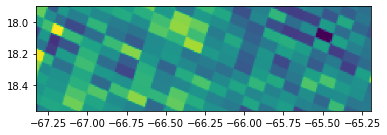

In [35]:
raster= rio.open(image)
sat_data= raster
show((raster,1))

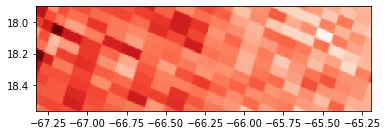

In [36]:
show((raster,4), cmap='Reds')

In [37]:
# Load the 12 bands into 2d arrays
b01, b02, b03, b04,b05, b06, b07, b08, b09, b10, b11, b12 = sat_data.read()

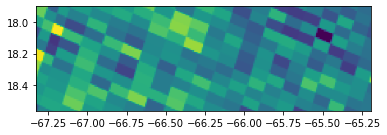

In [38]:
# Displaying the second band using rasterio
show((sat_data,2))

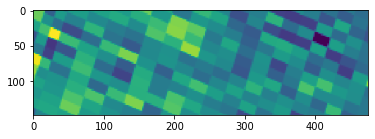

In [39]:
# Displaying the second band using matplotlib

fig = plt.imshow(b02)
plt.show()

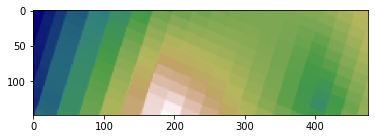

In [40]:
fig = plt.imshow(b03)
fig.set_cmap('gist_earth')
plt.show()

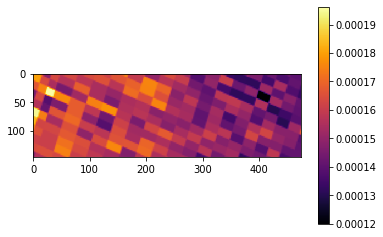

In [41]:
fig = plt.imshow(b04)
fig.set_cmap('inferno')
plt.colorbar()
plt.show()

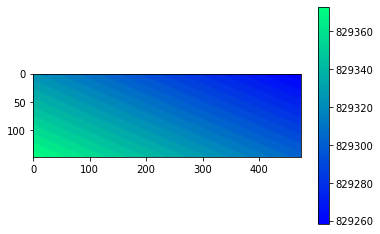

In [42]:
# Displaying the infrared band.

fig = plt.imshow(b08)
fig.set_cmap('winter')
plt.colorbar()
plt.show()

## Numerical extraction from .tif image file

In [43]:
image

'./eie_data/s5p_no2/s5p_no2_20180701T161259_20180707T175356.tif'

In [44]:
np.average(tiff.imread(image))

69914.70203940432

## Marginal emissions factor for each power plant
That is, for each power plant. The plant's energy generated versus the NO2 emissions (band 1) satellite imagery will be determined in order to compute a marginal emissions factor.

To be considered: stack .tif raster images by year (and/or month) to analyse change in emission factors over time